In [0]:
!pip install ipywidgets

In [0]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [0]:
import collections
import os
import io
#import StringIO
import sys
import tarfile
import tempfile
import urllib

from IPython import display
from ipywidgets import interact
from ipywidgets import interactive
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [8]:
tf.__version__

'1.12.0'

In [7]:
if tf.__version__ < '1.5.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.5.0 or newer!')

ImportError: ignored

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [12]:
path = '/content/gdrive/My Drive/MILIZE/Semantic/'

print (os.listdir(path))

['SemanticSeg.ipynb', 'DeepLab_v3_Test.ipynb', 'deeplab']


In [0]:
sys.path.append(path+'deeplab/utils')

In [0]:
import get_dataset_colormap

In [0]:
_MODEL_URLS = {
    'xception_coco_voctrainaug': 'http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval': 'http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}

Config = collections.namedtuple('Config', 'model_url, model_dir')

In [0]:
def get_config(model_name, model_dir):
    return Config(_MODEL_URLS[model_name], model_dir)

config_widget = interactive(get_config, model_name=_MODEL_URLS.keys(), model_dir='')

In [17]:
display.display(config_widget)

interactive(children=(Dropdown(description='model_name', options=('xception_coco_voctrainaug', 'xception_coco_…

In [34]:
# Check configuration and download the model

_TARBALL_NAME = 'deeplab_model.tar.gz'

config = config_widget.result

model_dir = config.model_dir or tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print (model_dir)
print ('downloading model to %s, this might take a while...' % download_path)

print (config.model_url)
urllib.request.urlretrieve(config.model_url, download_path)
print ('download completed!')

/tmp/tmprlmdtbtb
downloading model to /tmp/tmprlmdtbtb/deeplab_model.tar.gz, this might take a while...
http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz
download completed!


In [0]:
_FROZEN_GRAPH_NAME = 'frozen_inference_graph'


class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    #リサイズに影響される出力するファイルを変更したい場合はここを修正
    INPUT_SIZE = 513

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        
        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if _FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()
        
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():      
            tf.import_graph_def(graph_def, name='')
        
        self.sess = tf.Session(graph=self.graph)
            
    def run(self, image):
        """Runs inference on a single image.
        
        Args:
            image: A PIL.Image object, raw input image.
            
        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        print ('self.INPUT_SIZE: %s ' % self.INPUT_SIZE)
        print ('resize_ratio: %s ' % resize_ratio)
# リサイズに影響される出力するファイルを変更したい場合はここを修正
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

In [0]:
model = DeepLabModel(download_path)

In [0]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
    'train', 'tv'
])




FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = get_dataset_colormap.label_to_color_image(FULL_LABEL_MAP)


def vis_segmentation(image, seg_map):
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
    
    plt.subplot(grid_spec[1])
    seg_image = get_dataset_colormap.label_to_color_image(
        seg_map, get_dataset_colormap.get_pascal_name()).astype(np.uint8)

    im = np.array(seg_image)
    # 
    pil_img = Image.fromarray(im)
    #pil_img.save(path+'deeplab/g3doc/img/image1_4.jpg')
    pil_img.show()

    
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')
    
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0)
    

running deeplab on image image1.jpg...
self.INPUT_SIZE: 513 
resize_ratio: 0.8015625 


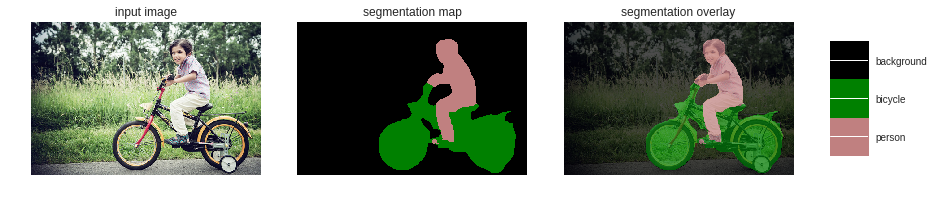

In [40]:
# Note that we are using single scale inference in the demo for fast
# computation, so the results may slightly differ from the visualizations
# in README, which uses multi-scale and left-right flipped inputs.

IMAGE_DIR = path+'deeplab/g3doc/img'

def run_demo_image(image_name):
    try:
        image_path = os.path.join(IMAGE_DIR, image_name)
        orignal_im = Image.open(image_path)
    except IOError:
        print ('Failed to read image from %s.' % image_path) 
        return 
    print ('running deeplab on image %s...' % image_name)
    resized_im, seg_map = model.run(orignal_im)
    
    vis_segmentation(resized_im, seg_map)

_ = interact(run_demo_image, image_name=['image1.jpg', 'image2.jpg', 'image3.jpg'])

running deeplab on image image6.jpg...
self.INPUT_SIZE: 513 
resize_ratio: 1.6132075471698113 


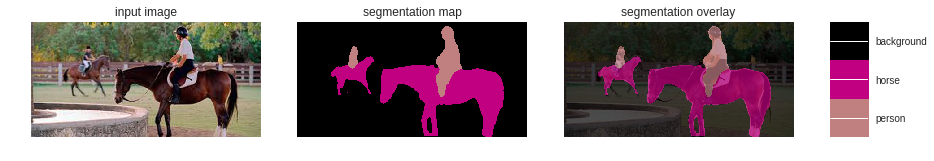

In [46]:
run_demo_image('image6.jpg')

In [38]:
url = 'https://cdn-ak.f.st-hatena.com/images/fotolife/m/masalib/20150818/20150818000442.jpg'
def get_an_internet_image(url):
    print ('test url: ' + url)
    if not url:
        return

    try:
        # Prefix with 'file://' for local file.
        if os.path.exists(url):
            url = 'file://' + url
        f = urllib.request.urlopen(url)
        jpeg_str = f.read()
    except IOError:
        print ('invalid url: ' + url)
        return

    orignal_im = Image.open(io.StringIO(jpeg_str))
    print ('running deeplab on image %s...' % url)
    resized_im, seg_map = model.run(orignal_im)
    print ('run end ')

    vis_segmentation(resized_im, seg_map)
    
##_ = interact(get_an_internet_image, url)

get_an_internet_image(url)


test url: https://cdn-ak.f.st-hatena.com/images/fotolife/m/masalib/20150818/20150818000442.jpg


TypeError: ignored